# 1. Temat jaki wybrałem to analiza sukcesu reklamy bankowej (reklamy dot. założenia lokaty w banku). Moim celem będzie zbadanie jakie cechy klientów wpływają na skłonność do założenia lokaty bankowej.
Niezbędne oprogramowanie to Python oraz biblioteki takie jak:
kaggle, pandas, numpy, seaborn, matplotlib, sklearn, scipy.
Rozwiązanie było testowane w *Google Colab, Streamlit oraz w środowisku Pycharm* 

In [45]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import chi2_contingency
pd.set_option('display.max_columns',None)

# 2. Dane pochodzą ze strony [Kaggle](https://www.kaggle.com/datasets/sahistapatel96/bankadditionalfullcsv), zostały zaimportowane przy użyciu biblioteki kaggle, więc nie ma potrzeby ich dodatkowego pobierania w sposób zewnętrzy. Dane te posiadają zaledwie kilkanaście procent sukcesu, co moim zdaniem prawidłowo oddaje specyfike problemu jakim jest marketing telefoniczny, który w większości nie przynosi efektu pozytywnego.

In [46]:
path = kagglehub.dataset_download("sahistapatel96/bankadditionalfullcsv")
df = pd.read_csv(path+'/bank-additional-full.csv', sep=';', na_values='unknown')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [47]:
df.housing.value_counts(dropna=False)

housing
yes    21576
no     18622
NaN      990
Name: count, dtype: int64

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [49]:
#zgodnie z opisem, badamy wpływ cech osobowych + związanych z poprzednimi kontaktami, więc odrzucamy cechy pracowników banków,
# które mogłyby wskazywać na interpersonalne umiejętności konsultantów, a nie na podatność konkretnych grup klientów
columns_to_drop = ['euribor3m','emp.var.rate','cons.price.idx','cons.conf.idx','nr.employed']
for column in columns_to_drop:
    df.drop(column, axis=1, inplace=True)

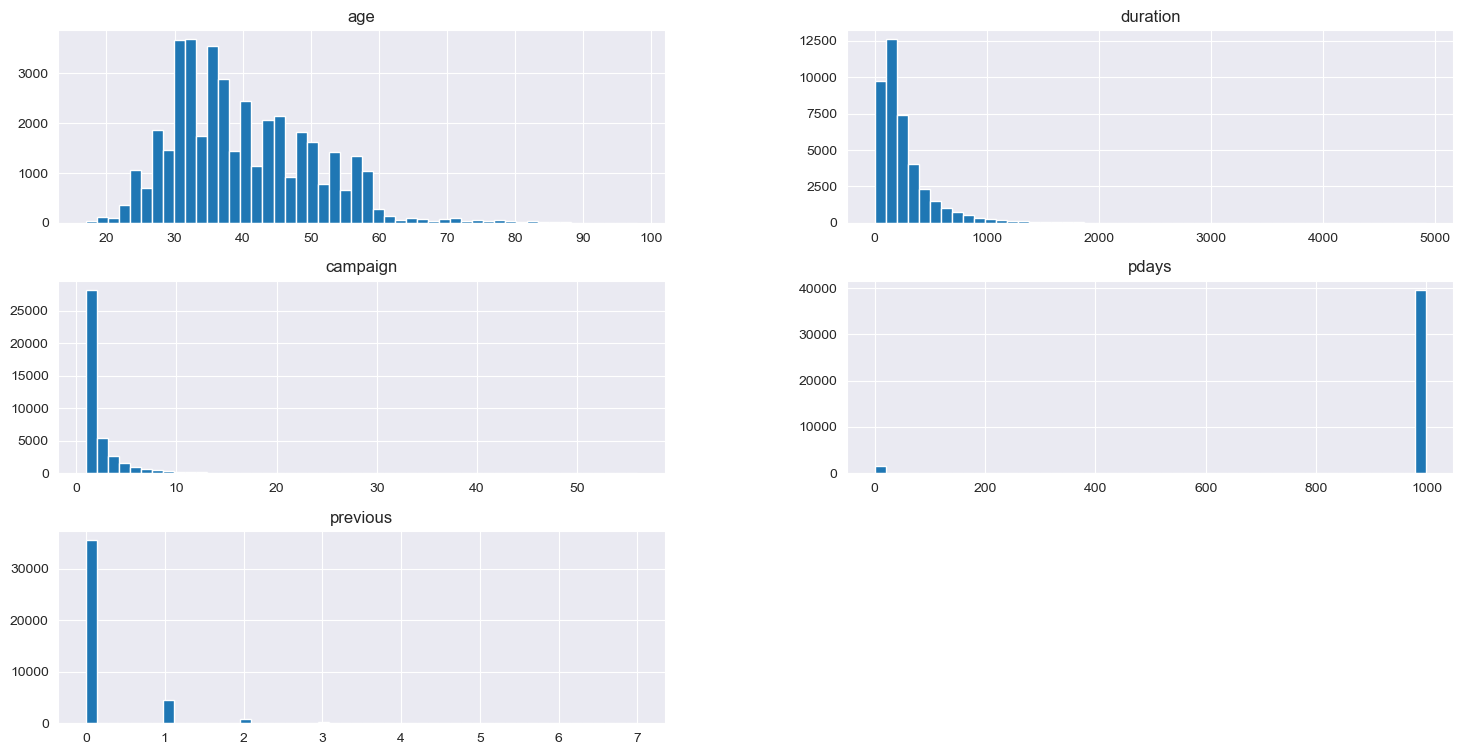

In [50]:
#spojrzenia na kolumny numeryczne przed ich standaryzacją, widać 3 wykresy lewostronne, jeden prawostrony (co jest przekłamaniem wynikającym z budowy danych, co omówie dalej) oraz wykres wieku wyglądający najlepiej ale dalej nie idealnie
df.hist(bins=50, figsize=(18,9))
plt.show()

In [51]:
#szybkie spojrzenia na dane jakie nam pozostały w tabeli
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,no


# 4a. Analiza przed zastosowaniem skalowania/standaryzacji

In [52]:
from itertools import combinations

categorical_columns = df.select_dtypes(exclude=[np.number]).columns
for col1, col2 in combinations(categorical_columns, 2):
    print(f"Analiza: {col1} vs {col2}")

    # Tworzymy tabelę krzyżową
    cross_tab = pd.crosstab(df[col1], df[col2])
    print("Tabela Krzyżowa:")
    print(cross_tab)

    # Test chi-kwadrat
    chi2, p, _, _ = chi2_contingency(cross_tab)
    print(f"Chi2: {chi2}")
    print(f"P-value: {p}")
    print("-" * 50)

Analiza: job vs marital
Tabela Krzyżowa:
marital        divorced  married  single
job                                     
admin.             1280     5253    3875
blue-collar         728     6687    1825
entrepreneur        179     1071     203
housemaid           161      777     119
management          331     2089     501
retired             348     1274      93
self-employed       133      904     379
services            532     2294    1137
student               9       41     824
technician          774     3670    2287
unemployed          124      634     251
Chi2: 4045.117713451801
P-value: 0.0
--------------------------------------------------
Analiza: job vs education
Tabela Krzyżowa:
education      basic.4y  basic.6y  basic.9y  high.school  illiterate  \
job                                                                    
admin.               77       151       499         3329           1   
blue-collar        2318      1426      3623          878           8   
entrepr

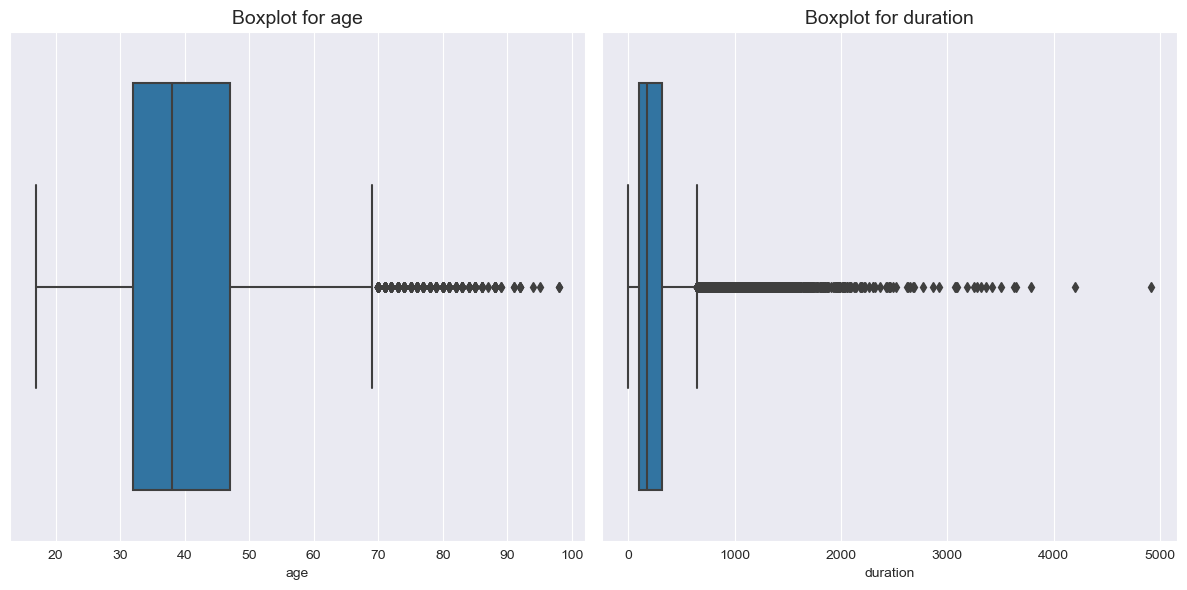

In [53]:
selected_columns = ['age', 'duration']

fig, axes = plt.subplots(1, len(selected_columns), figsize=(12, 6))

for i, column in enumerate(selected_columns):
    sns.boxplot(data=df, x=column, ax=axes[i])
    axes[i].set_title(f"Boxplot for {column}", fontsize=14)

plt.tight_layout()
plt.show()

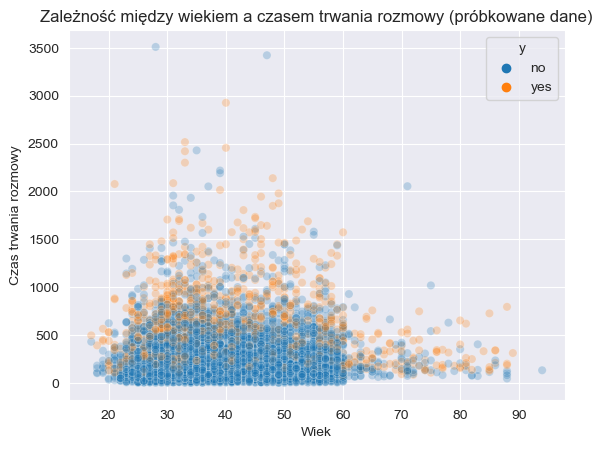

In [54]:
sampled_df = df.sample(n=10000, random_state=42)

# Wykres rozrzutu z próbkowanymi danymi i przezroczystością
sns.scatterplot(x='age', y='duration', data=sampled_df, hue='y', alpha=0.25)
plt.title('Zależność między wiekiem a czasem trwania rozmowy (próbkowane dane)')
plt.xlabel('Wiek')
plt.ylabel('Czas trwania rozmowy')
plt.show()

C:\Users\marek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



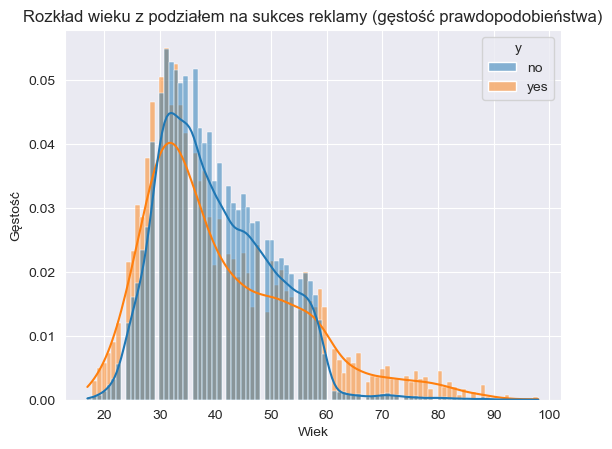

In [55]:
# Histogram z gęstością prawdopodobieństwa i oddzielną normalizacją dla każdej grupy
sns.histplot(x='age', data=df, hue='y', stat="density", common_norm=False, kde=True)
plt.title('Rozkład wieku z podziałem na sukces reklamy (gęstość prawdopodobieństwa)')
plt.xlabel('Wiek')
plt.ylabel('Gęstość')
plt.show()

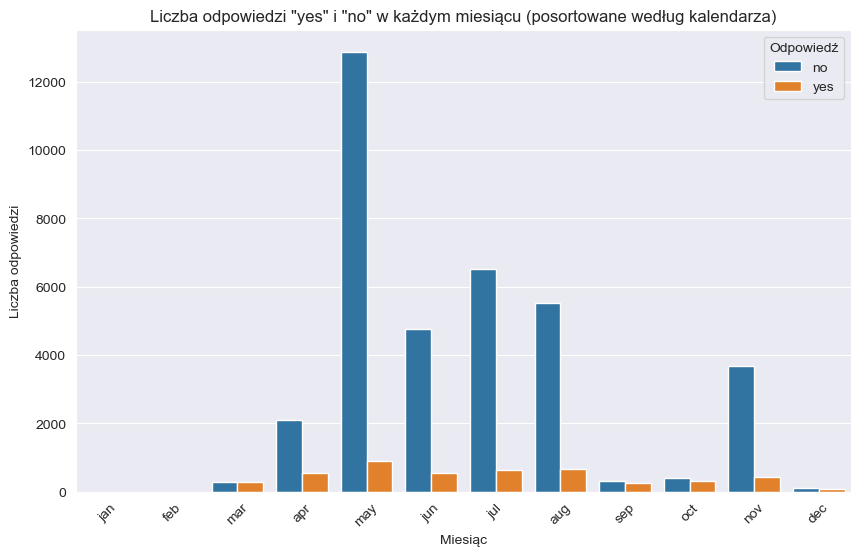

In [56]:
monthly_counts = df.groupby(['month', 'y'])['y'].count().reset_index(name='count')
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']  

plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='count', hue='y', data=monthly_counts, order=month_order)  
plt.title('Liczba odpowiedzi "yes" i "no" w każdym miesiącu (posortowane według kalendarza)')
plt.xlabel('Miesiąc')
plt.ylabel('Liczba odpowiedzi')
plt.xticks(rotation=45)
plt.legend(title='Odpowiedź')
plt.show()

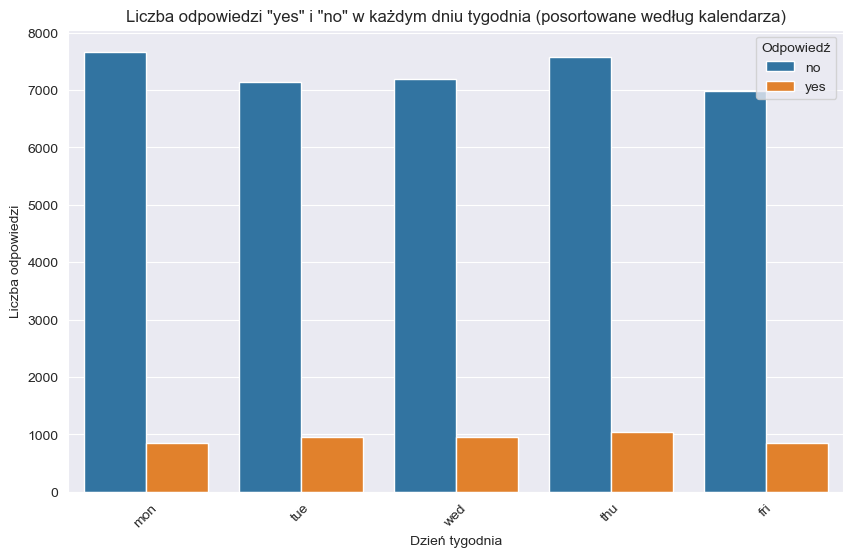

In [57]:
day_counts = df.groupby(['day_of_week', 'y'])['y'].count().reset_index(name='count')
day_order = ['mon', 'tue', 'wed', 'thu', 'fri'] 

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='count', hue='y', data=day_counts, order=day_order)  
plt.title('Liczba odpowiedzi "yes" i "no" w każdym dniu tygodnia (posortowane według kalendarza)')
plt.xlabel('Dzień tygodnia')
plt.ylabel('Liczba odpowiedzi')
plt.xticks(rotation=45)
plt.legend(title='Odpowiedź')
plt.show()

In [58]:
import plotly.express as px
# Wykres dla miesięcy
monthly_counts = df.groupby(['month', 'y'])['y'].count().reset_index(name='count')

month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

fig_month = px.bar(monthly_counts, 
                   x='month', 
                   y='count', 
                   color='y', 
                   category_orders={'month': month_order},  
                   title='Liczba odpowiedzi "yes" i "no" w każdym miesiącu',
                   labels={'month': 'Miesiąc', 'count': 'Liczba odpowiedzi', 'y': 'Odpowiedź'},
                   barmode='group')  
fig_month.show()

# 3. Czyszczenie danych zostało zaprezentowane poniżej, wartości odstające zostały usunięte, następnie poddano je skalowaniu dla lepszego efektu uczenia maszynowego. Dla niektórych kolumn zastosowano specjalistyczne podejście co opiszę poniżej.

In [59]:
#metoda scaleMinMax przyśpieszy proces skalowania
def scaleMinMax(dataFrame, columnName):
    scaler = MinMaxScaler()
    series = dataFrame[columnName]
    scaled_data = scaler.fit_transform(series.values.reshape(-1,1))
    scaled_series = pd.Series(scaled_data.flatten(), index=series.index)
    dataFrame[columnName] = scaled_series

In [60]:
#najpierw skalujemy kolumnę wiek w wartości od 0 do 1, kolumna age nie posiada danych brakujących
scaleMinMax(df, 'age')

In [61]:
#teraz zajmiemy się kolumnami Job i Marital, dla obu zastosujemy dummmy typing, usuwając najpierw rekordy z NaN (wcześniej unknown)
categorical_for_dummies = ['job', 'marital']
[df.dropna(subset=x, inplace=True) for x in categorical_for_dummies]
#kolumny default, housing, loan i contact dodajemy do listy, by również poddać je typowaniu
categorical_for_dummies.extend(['default', 'housing','loan','contact','poutcome'])
df = pd.get_dummies(df, columns=categorical_for_dummies)

In [62]:
#teraz zajmiemy się edukacją zamieniłem poziom nauki na wartości 0-6 obrazujące ile ktoś się uczył (jaki uzyskał tytuł)
#dodatkowo wartości brakujące uzupełniłem średnią, na koniec zastosowałem skaler
education_mapping = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6
}
df['education'] = df['education'].map(education_mapping)

df['education'] = df['education'].fillna(df['education'].mean())

scaleMinMax(df, 'education')

In [63]:
#teraz zamienimy miesiące i dni tygodnia na wartośći 1-12 oraz 1-5, następnie poddamy je skalowaniu
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
df['month'] = df['month'].map(month_mapping)


day_mapping = {
    'mon': 1, 'tue': 2, 'wed': 3,
    'thu': 4, 'fri': 5
}
df['day_of_week'] = df['day_of_week'].map(day_mapping)

scaleMinMax(df, 'month')
scaleMinMax(df, 'day_of_week')

In [64]:
#Teraz zajmiemy się kolumną campaign, odrzucimy 0.5% największych ilości kontaktów. Powyżej 19 kontaktów współczynnik sukcesu wyniósł w naszym zbiorze 1/186
quantile_995 = df['campaign'].quantile(0.995)
df = df.loc[df['campaign'] <= quantile_995].copy()
scaleMinMax(df, 'campaign')

In [65]:
#dostawiłem dodatkową kolumnę z brakiem kontaktu wcześniejszego oraz wykonałem log10, by ułatwił uczeniu maszynowemu predykcję
#wynika to ze struktury danych gdzie 999 oznaczało w zbiorze brak kontaktu, a wstawiono to do kolumny pdays
df.loc[:, 'not_contacted_before'] = df['pdays'] == 999
df['pdays'] = df['pdays'].apply(lambda x: np.log10(x) if x > 0 else 0)

In [66]:
#dla previous i duration wykonałem tylko standardowy scaling MinMax
scaleMinMax(df, 'previous')
scaleMinMax(df, 'duration')

In [67]:
#odpowiedż została zmieniona z kategorycznej na binarne 0 i 1
y_mapping = {'no': 0, 'yes': 1}
df['y'] = df['y'].map(y_mapping)

X = df.drop('y', axis=1)
Y = df['y']

# 4. Analiza danych zbioru wstępnie przetworzonego

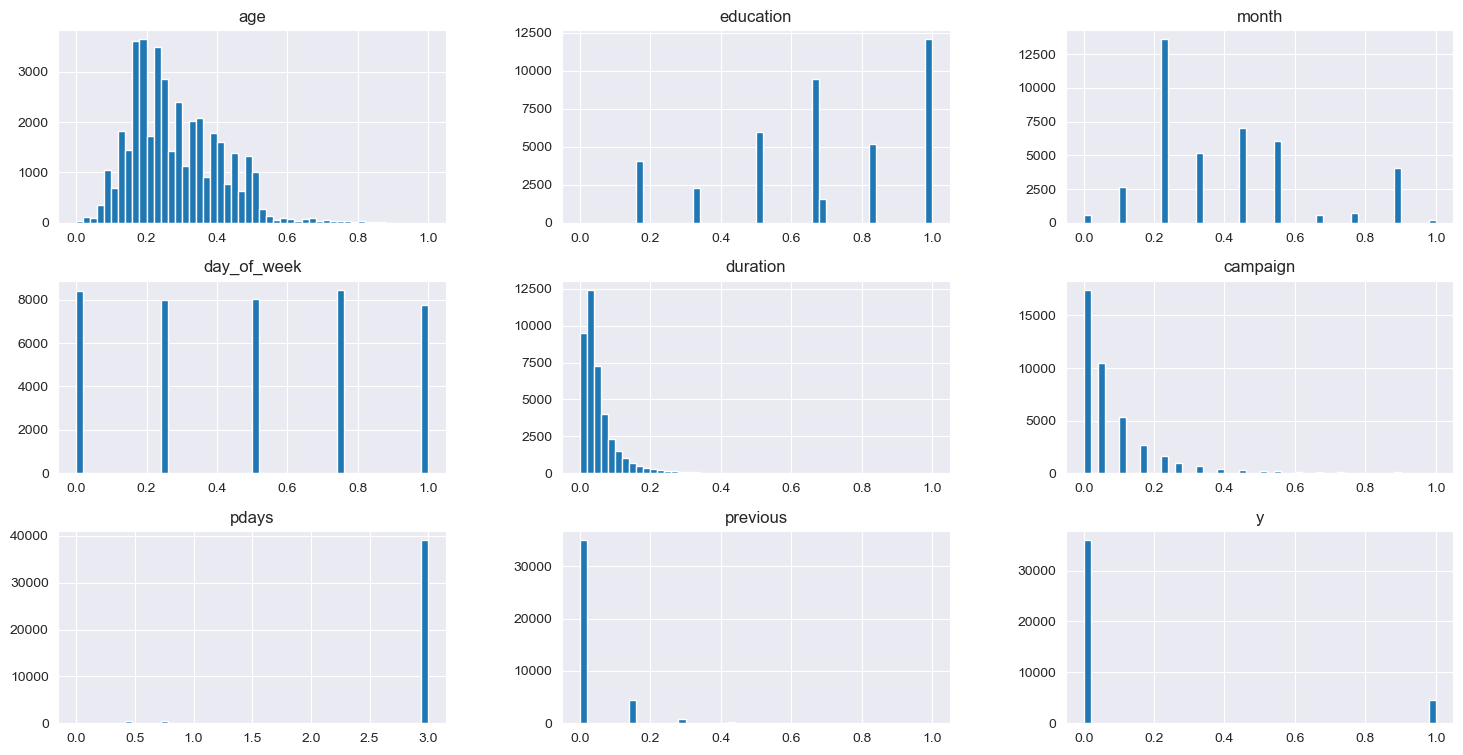

In [68]:
#Po etapie czyszczenia danych doszły nam 4 kolumny, które przeszły z typu kategorycznego na typ numeryczny ich rozkład można nazwać normalnym
#wartości kolumn campaign, duration oraz previous zostały przeskalowane dzięki czemu ich wartości krańcowe nie są tak odległe od siebie
#pdays prawdopodobnie należałoby usunąć, co sprawdzimy dalej.
df.hist(bins=50, figsize=(18,9))
plt.show()

In [69]:
#jak widać, kolumnny kategoryczne po przejściu przez dummy_encoder dodały nam kilkanaście nowych wartości, co powinno pomóc modelom uczenia maszynowego
df.head()

,age,education,month,day_of_week,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,not_contacted_before
0,0.481481,0.166667,0.222222,0.0,0.053070,0.0,2.999565,0.0,0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,False,True,False,True,False,True
1,0.493827,0.666667,0.222222,0.0,0.030297,0.0,2.999565,0.0,0,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,True,False,True
2,0.246914,0.666667,0.222222,0.0,0.045954,0.0,2.999565,0.0,0,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,True,False,False,True,False,True,False,True
3,0.283951,0.333333,0.222222,0.0,0.030704,0.0,2.999565,0.0,0,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,False,True,False,True,False,True
4,0.481481,0.666667,0.222222,0.0,0.062424,0.0,2.999565,0.0,0,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,True,False,True,False,True,False,True


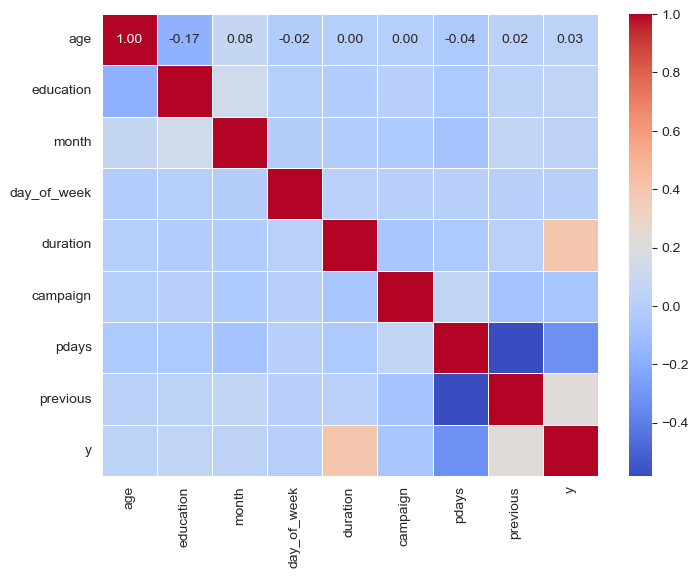

In [70]:
#na poniższym wykresie widać, że najmocniej skorelowanymi zmiennymi numerycznymi do y jest czas trwania rozmowy z konsultantem (duration),
#oraz to czy klient doświadczył już innych kontaktów przed tą kampanią (previous),
#ilość dni od ostatniego kontaktu (pdays) jest dodatkowo mocno skorelowane z tym czy wystąpił kontakt co jest naturalne
#pozostałe kolumny można opisać jako słabo skorelowane ze zmienną y
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [71]:
#na podstawie powyższego usuwam kolumne pdays ze zbioru
df.drop('pdays', axis=1, inplace=True)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

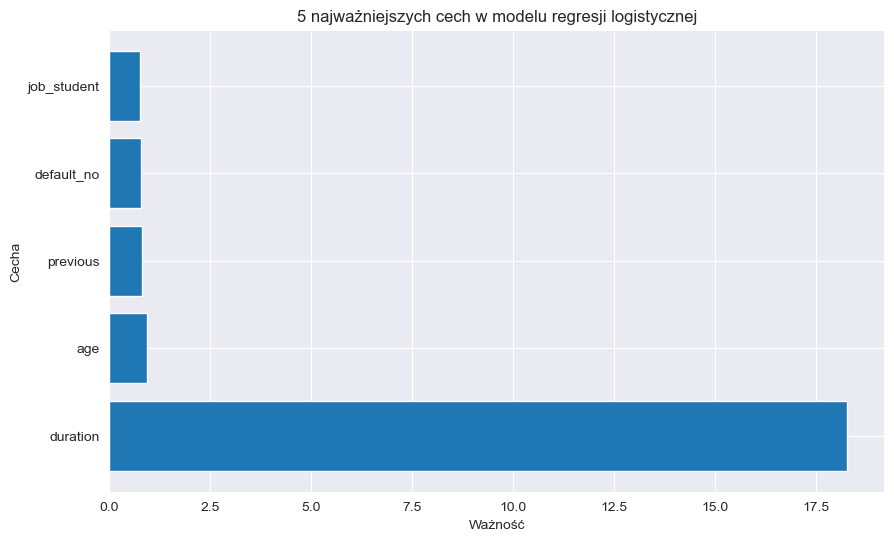

In [73]:
from sklearn.linear_model import LogisticRegression

# Regresja logistyczna do przewidywania sukcesu reklamy
model = LogisticRegression()
model.fit(X_train, y_train)
importances = model.coef_[0]
features = X_train.columns

feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
top_5_features = feature_importances.sort_values('importance', ascending=False).head(5)
# Wizualizacja ważności cech
plt.figure(figsize=(10, 6))
plt.barh(top_5_features['feature'], top_5_features['importance'])
plt.title('5 najważniejszych cech w modelu regresji logistycznej')
plt.xlabel('Ważność')
plt.ylabel('Cecha')
plt.show()

# 6. Poniżej przedstawiam modelowanie, program dotyczy klasyfikacji binarnej, gdzie 0 oznacza brak chęci do założenia lokaty bankowej, a 1 pozytywny wynik marketingu czyli założenie takiej lokaty. Przedstawiam kilka modeli uczenia maszynowego, sposród których wybrałem 1 moim zdaniem najkorzystniejszy.

In [74]:
#metoda createMetrics pozwala na szybsze tworzenie jednolitych macierzy pomyłek używając skali logarytmicznej
def createMetrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred,  labels=[1,0])

    plt.figure(figsize=(6, 4))
    plt.imshow(np.log1p(cm), interpolation='nearest', cmap='Greens')
    plt.title('Macierz pomyłek (log)')
    plt.colorbar()

    plt.xticks([])
    plt.yticks([])

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == 0 and j == 0:
                plt.text(j, i, f'TP={cm[i, j]}', horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
            elif i == 0 and j == 1:
                plt.text(j, i, f'FN={cm[i, j]}', horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
            elif i == 1 and j == 0:
                plt.text(j, i, f'FP={cm[i, j]}', horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
            elif i == 1 and j == 1:
                plt.text(j, i, f'TN={cm[i, j]}', horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.show()

    print(classification_report(y_test, y_pred))

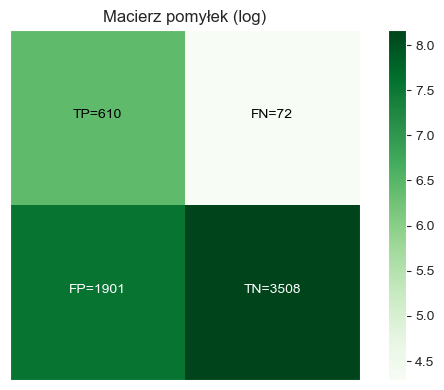

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      5409
           1       0.24      0.89      0.38       682

    accuracy                           0.68      6091
   macro avg       0.61      0.77      0.58      6091
weighted avg       0.90      0.68      0.74      6091



In [75]:
from sklearn.tree import DecisionTreeClassifier
#Drzewa decyzyjne
model = DecisionTreeClassifier(max_depth = 3,class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

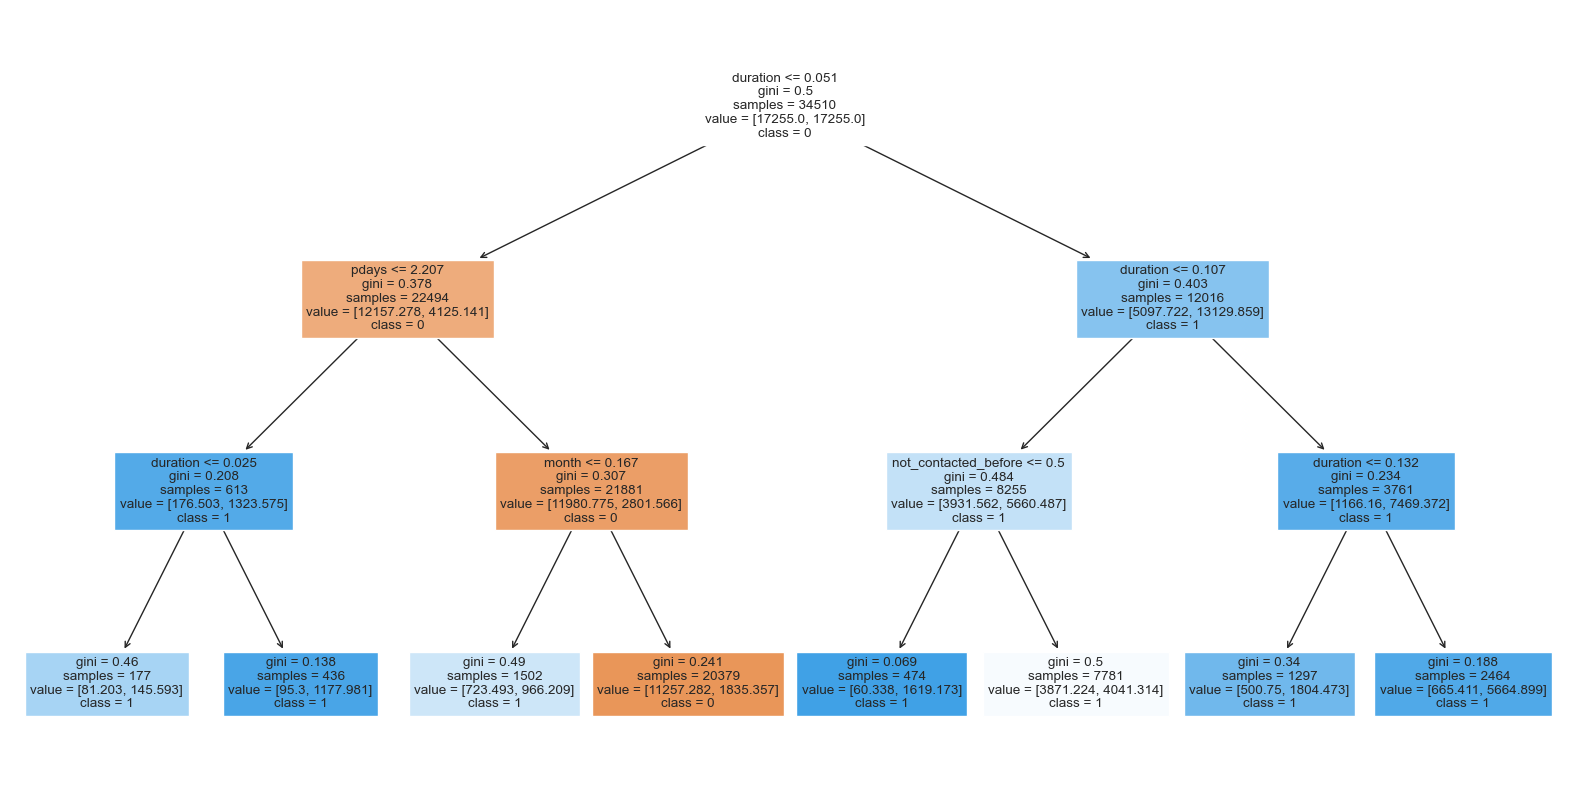

In [76]:
#poniżej graficzna reprezentacja drzewa decyzyjnego, oraz jego cech decyzyjnych.
#czym bardziej niebieskie tym bardziej pewne jest drzewo swojej decyzji negatywnej
#analogicznie czym bardziej pomarańczowe tym bardziej jest pewne decyzji pozytywnej
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))

feature_names = X_train.columns
class_names = model.classes_

feature_names = list(map(str, feature_names))
class_names = list(map(str, class_names))

plot_tree(model, feature_names=feature_names, class_names=class_names, filled=True)
plt.show()

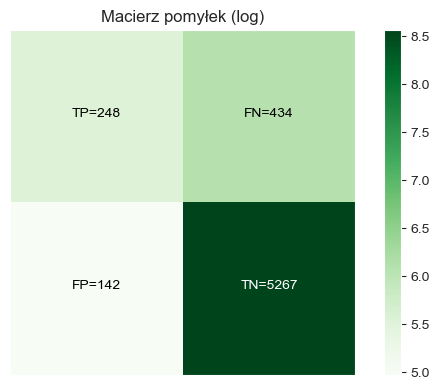

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5409
           1       0.64      0.36      0.46       682

    accuracy                           0.91      6091
   macro avg       0.78      0.67      0.71      6091
weighted avg       0.89      0.91      0.89      6091



In [77]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

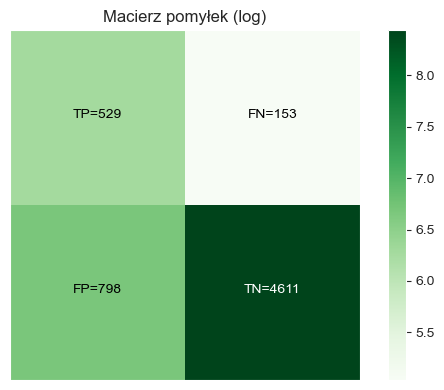

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      5409
           1       0.40      0.78      0.53       682

    accuracy                           0.84      6091
   macro avg       0.68      0.81      0.72      6091
weighted avg       0.90      0.84      0.86      6091



In [78]:
from sklearn.svm import SVC

model = SVC(class_weight='balanced', random_state=42, probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

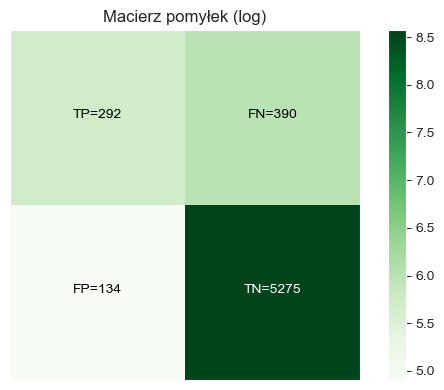

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5409
           1       0.69      0.43      0.53       682

    accuracy                           0.91      6091
   macro avg       0.81      0.70      0.74      6091
weighted avg       0.90      0.91      0.91      6091



In [79]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

C:\Users\marek\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



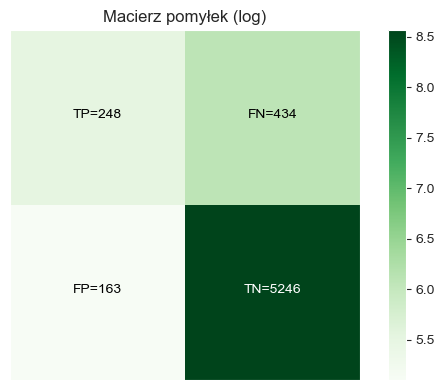

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5409
           1       0.60      0.36      0.45       682

    accuracy                           0.90      6091
   macro avg       0.76      0.67      0.70      6091
weighted avg       0.89      0.90      0.89      6091



In [80]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

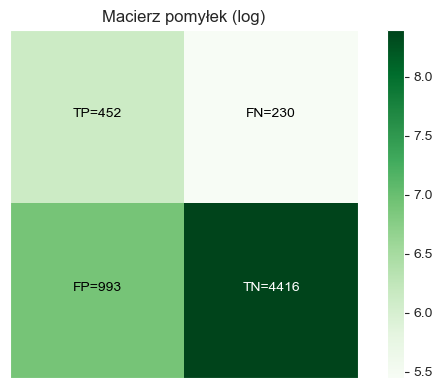

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      5409
           1       0.31      0.66      0.43       682

    accuracy                           0.80      6091
   macro avg       0.63      0.74      0.65      6091
weighted avg       0.88      0.80      0.83      6091



In [81]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

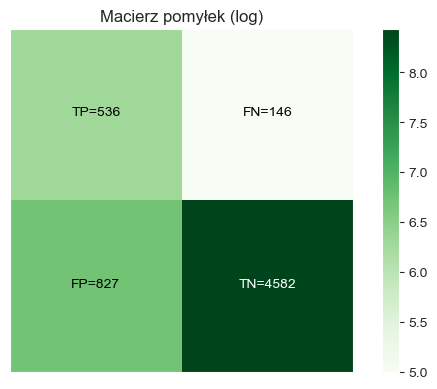

              precision    recall  f1-score   support

           0       0.97      0.85      0.90      5409
           1       0.39      0.79      0.52       682

    accuracy                           0.84      6091
   macro avg       0.68      0.82      0.71      6091
weighted avg       0.90      0.84      0.86      6091



In [82]:
#jako rozwiązanie najlepsze, został wybrany VotingClassifier z głosowaniem twardym
#oznacza to że 3 modele podejmuja decyzję, a ostateczna decyzja podejmowana jest większościowo
#pozwala to na zwiększenie wiarygodności wyniku, ponieważ większość modeli musiała w ten sam sposób decydować.
#modele w które wchodzą w jego skład zostały wybrane na podstawie jak najlepszej wartości TP,
#ponieważ nie ma kary za niepoprawną predykcję złego marketingu.
#Można wybrać modele o większej dokładności, ale zmniejszy to zyski banku
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('svc', SVC(class_weight='balanced', random_state=42, probability=True)),
        ('dtc',DecisionTreeClassifier(max_depth = 10,class_weight='balanced', random_state=42)),
        ('gnb',GaussianNB())
    ]
)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

createMetrics(y_test, y_pred)

In [83]:
#RandomizedSearchCV pozwala na znalezienie najlepszych wartości dla modeli, został zakomentowany z racji długiego czasu wykonania

# from sklearn.model_selection import RandomizedSearchCV

# param_distributions = {
#     'svc__C': [0.1, 1, 10, 100],
#     'svc__kernel': ['linear', 'rbf', 'poly'],
#     'dtc__max_depth': [None, 10, 20, 30, 40],
#     'dtc__min_samples_split': [2, 5, 10, 15],
#     'gnb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
# }

# # Przeszukiwanie hiperparametrów
# random_search = RandomizedSearchCV(voting_clf, param_distributions, n_iter=50, cv=5, scoring='recall', verbose=1, random_state=42)
# random_search.fit(X_train, y_train)

# # Wyniki
# print("Najlepsze parametry:")
# print(random_search.best_params_)
# y_pred = random_search.predict(X_test)

# createMetrics(y_test, y_pred)